# Part2: Control a Marble with Reinforcement Learning

Fawad Ahmad

## Overview

This Includes the first extra credit which involves the change of marble world from one dimension to two. Some important Points to consider are as following.

* In order to make the dimensions 2D, I am considering Y-axis too. 
* Position and velocity of the marble in X direction is independent of the Position and velocity of marble in Y direction.
* So reinforcemet and all other parameters for X-axis direction will be different and independent of Y-axis direction.
* So I have trained two qnets which together achieve single goal. 

## Functions

Following is the Discription of functions.
* $initialState$ is to get the starting parameters which in this case are position and Velocity.
* $nextState$ is to get the next state in terms of position and velocity.
* $reinforcement$ is to look for the goal and current position difference and reinforce accordingly.
* $policy$ is to get new action randomly or by looking into the qnet for a good action.
* $makeSamples$ is to get all the samples considering one starting point so that when we give it to the system, it learns better.
* $plotStatus$ is to generate different plots to show reinforcements,actions,NN, MaxQ and relation of position with velocity. The only difference here is that it shows graphs for X and Y axis both. And also shows the movement of marble in 2D and 3D.


In [1]:
import neuralnetworksbylayer as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import copy

%matplotlib inline

In [2]:
validActions = np.array([ -1, 0, 1])

def initialState():
    return np.array([10*np.random.random_sample(), 3*(0.5-np.random.random_sample())])

def nextState(s,a):
    s = copy.copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = np.array([0,0])
    elif s[0] > 10:
        s = np.array([10,0])
    return s

def reinforcement(s):  # s is new state
    goal = 5
    return 0 if abs(s[0]-goal) < 1 else -0.1

def policy(qnet, state, epsilon):
    if np.random.rand(1) < epsilon:
        actioni = np.random.randint(validActions.shape[0])
    else:
        inputs = np.hstack(( np.tile(state, (validActions.shape[0], 1)), validActions.reshape((-1,1))))
        qs = qnet.use(inputs)
        actioni = np.argmax(qs)
    return validActions[actioni]

Now we need a function to generate a bunch of samples that are interactions with the marble.

In [3]:
def makeSamples(qnet, nStepsPerStart):
    samples = []
    state = initialState()
    act = policy(qnet, state, epsilon)
    oldact = act
    for iStep in range(nStepsPerStart):
        newState = nextState(state, act)
        r = reinforcement(newState)
        newAct = policy(qnet, newState, epsilon)
        # SARSA
        samples.append(state.tolist() + [act, r] + newState.tolist() + [newAct])
        state = newState
        oldact = act
        act = newAct
    return np.array(samples)

### Graphs Function
I have saperated the y-axis and x-axis graphs and then have shown the graph which shows there combined action.

In [7]:
def plotStatus(qnet,qnet1, X,Y, R,R1, trial,epsilonTrace,rtrace,rtrace1):
    
    plt.subplot(4,4,1)
    plt.plot(epsilonTrace[:trial+1])
    plt.ylabel("Random Action Probability ($\epsilon$)")
    plt.ylim(0,1)
    
    
    plt.subplot(4,4,2)
    plt.plot(X[:,0])
    plt.plot([0,X.shape[0]], [5,5],'--',alpha=0.5,lw=5)
    plt.ylabel("$x$")
    plt.ylim(-1,11)
    #qs = [[qnet.use([s,0,a]) for a in actions] for s in range(11)]
    qs = qnet.use(np.array([[s,0,a] for a in validActions for s in range(11)]))
    #print np.hstack((qs,-1+np.argmax(qs,axis=1).reshape((-1,1))))
    
    
    plt.subplot(4,4,3)
    plt.plot(rtrace[:trial+1],alpha=0.5)
    #plt.plot(np.convolve(rtrace[:trial+1],np.array([0.02]*50),mode='valid'))
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement of x")
    
    
    plt.subplot(4,4,4)
    plt.plot(rtrace1[:trial+1],alpha=0.5)
    #plt.plot(np.convolve(rtrace[:trial+1],np.array([0.02]*50),mode='valid'))
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace1[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement of y")
    
    
    plt.subplot(4,4,5)
    plt.plot(X[:,0],X[:,1])
    plt.plot(X[0,0],X[0,1],'o')
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.fill_between([4,6],[-5,-5],[5,5],color="red",alpha=0.3)
    plt.xlim(-1,11)
    plt.ylim(-5,5)

    plt.subplot(4,4,6)
    plt.plot(Y[:,0],Y[:,1])
    plt.plot(Y[0,0],Y[0,1],'o')
    plt.xlabel("$y$")
    plt.ylabel("$\dot{y}$")
    plt.fill_between([4,6],[-5,-5],[5,5],color="red",alpha=0.3)
    plt.xlim(-1,11)
    plt.ylim(-5,5)
    
    plt.subplot(4,4,7)
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    #states = np.vstack((xs.flat,ys.flat)).T
    #qs = [qnet.use(np.hstack((states,np.ones((states.shape[0],1))*act))) for act in actions]
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i],ysflat[i],a] for a in validActions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q")
    
    plt.subplot(4,4,8)
    acts = np.array(validActions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Actions")

    s = plt.subplot(4,4,9)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Max Q")
    plt.title("Max Q")


    plt.subplot(4,4,10)
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    #states = np.vstack((xs.flat,ys.flat)).T
    #qs = [qnet.use(np.hstack((states,np.ones((states.shape[0],1))*act))) for act in actions]
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet1.use(np.array([[xsflat[i],ysflat[i],a] for a in validActions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$y$")
    plt.ylabel("$\dot{y}$")
    plt.title("Max Q")
    

    s = plt.subplot(4,4,11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$y$")
    ax.set_ylabel("$\dot{y}$")
    #ax.set_zlabel("Max Q")
    plt.title("Max Q")


    plt.subplot(4,4,12)
    plt.plot(X[:,0],Y[:,0])
    plt.plot(X[0,0],Y[0,0],'o')
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.fill_between([4,6],[-5,-5],[11,11],color="red",alpha=0.3)
    plt.xlim(-1,11)
    plt.ylim(-1,11)
    
    s = plt.subplot(4,4,13)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)    
    ax.plot(X[:,0], Y[:,0], (2 ** X[:,1]) + (2 ** Y[:,1])**(1/2.0), zdir='z', label='ys=0, zdir=z')
    ax.scatter(X[0,0], Y[0,0], (2 ** X[0,1]) + (2 ** Y[0,1])**(1/2.0))
    #plt.plot(X[0,0],X[0,1],'o')
    #ax.fill_between([4,6],[-5,-5],[5,5],color="red",alpha=0.3)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("Velocity")
    plt.title(" Average Velocity vs position")  

In [8]:
gamma = 0.999
nTrials = 300
nStepsPerTrial = 500 
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value
nh = [5,5]
qnet = nn.NeuralNetwork([3] + nh + [1])  # [3, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (-1,1)))
qnet1 = nn.NeuralNetwork([3] + nh + [1])  # [3, 5, 5, 1]
qnet1.setInputRanges(( (0, 10), (-3, 3), (-1,1)))

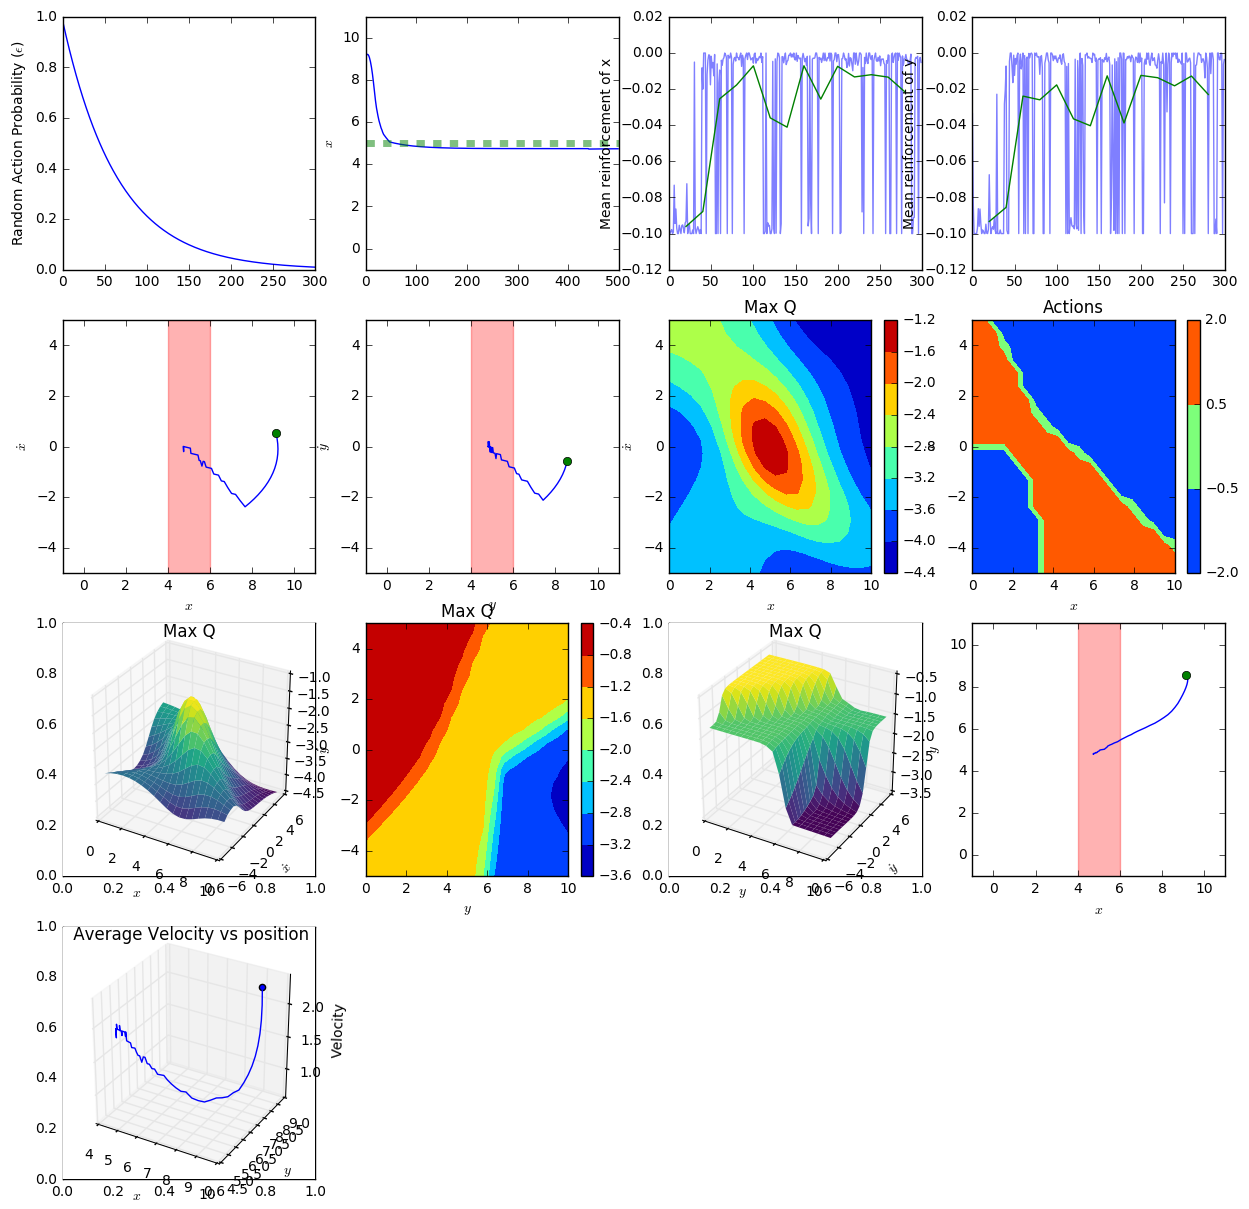

In [9]:
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
rtrace1 = np.zeros(nTrials)
for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    # FOR X
    samples = makeSamples(qnet, nStepsPerTrial)
    ns = 2
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)
    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    
    # FOR Y
    
    samples = makeSamples(qnet, nStepsPerTrial)
    Y = samples[:, :ns+na]
    R1 = samples[:, ns+na:ns+na+1]
    nextY = samples[:, ns+na+1:]
    nextQ1 = qnet.use(nextX)
    qnet1.train(Y, R1 + gamma * nextQ1, nIterations = nSCGIterations)
    
    
    
    
    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)
    rtrace1[trial] = np.mean(R1)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet,qnet1, X,Y, R,R1, trial,epsilonTrace,rtrace,rtrace1)
        #testIt(qnet,10,500)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

### Analysis:

Following are the analysis of the 2d dimensional graphs:
* Learning of both X and Y is fast towards the goal which is shown in reinforcement graphs.
* Individual graphs of X and Y with there velocities shows smooth transition towards goal.
* The second last graph shows the movement of marble by taking both the values to achieve the goal.
* Last graph shows the movement by cosidering the velocity as the third factor, where velocity is the net of both X and Y combined and it's used just to get the visual demonstration of 3D world.